In [1]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
from jax import random

import numpy as np

import gpx
from gpx.models import SGPR
from gpx.kernels import SquaredExponential
from gpx.utils import softplus, inverse_softplus, identity

import matplotlib.pyplot as plt

plt.style.use("dark_background")

%load_ext autoreload
%autoreload 2

In [2]:
def func(x):
    """Latent function."""
    return (
        1.0 * jnp.sin(x * 3 * jnp.pi)
        + 0.3 * jnp.cos(x * 9 * jnp.pi)
        + 0.5 * jnp.sin(x * 7 * jnp.pi)
    )


# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)


every = 100
X_locs = X[::every]
y_locs = y[::every]
f_locs = func(X_locs)

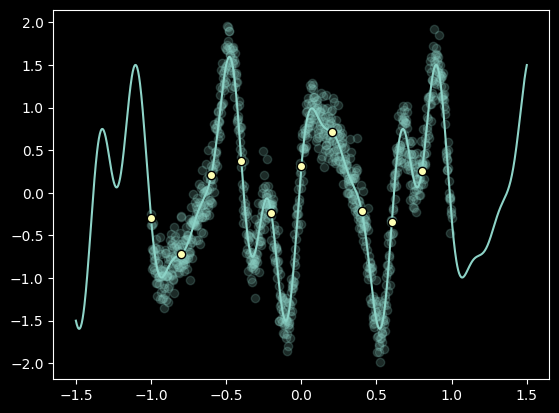

In [3]:
plt.scatter(X, y, alpha=0.2)
plt.plot(X_test, f_true)
plt.scatter(X_locs, f_locs, zorder=99, ec="k")

In [4]:
model = SGPR(
    kernel=SquaredExponential(),
    kernel_params=dict(lengthscale=(1.0, True, softplus, inverse_softplus)),
    sigma=(1.0, True, softplus, inverse_softplus),
    x_locs=(X_locs, False, identity, identity),
)

In [5]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬─────────────┬─────────┬─────────┬────────────────┐
│ name               │ trainable   │ forward   │ backward         │ type        │ dtype   │ shape   │ value          │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼────────────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 1.             │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼────────────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 1.             │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼────────────────┤
│ x_locs             │ False       │ identity  │ identity         │ DeviceArray │ float64 │ (10, 1) │ [[-1.       ]  │
│                    │             │           │

In [6]:
model.fit(X, y, minimize_lml=True)

In [7]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬─────────────┬─────────┬─────────┬────────────────┐
│ name               │ trainable   │ forward   │ backward         │ type        │ dtype   │ shape   │ value          │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼────────────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 0.26255848     │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼────────────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 0.46089226     │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼────────────────┤
│ x_locs             │ False       │ identity  │ identity         │ DeviceArray │ float64 │ (10, 1) │ [[-1.       ]  │
│                    │             │           │

In [8]:
model.log_marginal_likelihood(X, y)

DeviceArray(-671.92540265, dtype=float64)

In [9]:
y_pred, cov_pred = model.predict(X_test, full_covariance=True)
err = 2 * jnp.diag(cov_pred) ** 0.5

# model prediction at input locations
y_locs_pred = model.predict(model.x_locs_)

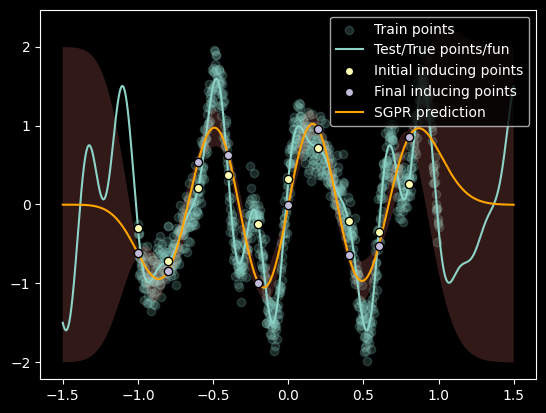

In [10]:
plt.scatter(X, y, alpha=0.2, label="Train points")
plt.plot(X_test, f_true, label="Test/True points/fun")
plt.scatter(X_locs, f_locs, zorder=99, ec="k", label="Initial inducing points")
plt.scatter(model.x_locs_, y_locs_pred, ec="k", zorder=99, label="Final inducing points")
plt.plot(X_test, y_pred, c="orange", label="SGPR prediction")
plt.fill_between(
    X_test.reshape(-1), y_pred.reshape(-1) - err, y_pred.reshape(-1) + err, alpha=0.2
)
plt.legend()

Optimizing input locations

In [13]:
model = SGPR(
    kernel=SquaredExponential(),
    kernel_params=dict(lengthscale=(1.0, True, softplus, inverse_softplus)),
    sigma=(1.0, True, softplus, inverse_softplus),
    x_locs=(X_locs, True, identity, identity),
)

In [14]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬─────────────┬─────────┬─────────┬────────────────┐
│ name               │ trainable   │ forward   │ backward         │ type        │ dtype   │ shape   │ value          │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼────────────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 1.             │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼────────────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 1.             │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼────────────────┤
│ x_locs             │ True        │ identity  │ identity         │ DeviceArray │ float64 │ (10, 1) │ [[-1.       ]  │
│                    │             │           │

In [15]:
model.fit(X, y)

In [16]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬─────────────┬─────────┬─────────┬─────────────────┐
│ name               │ trainable   │ forward   │ backward         │ type        │ dtype   │ shape   │ value           │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼─────────────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 0.07727279      │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼─────────────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 0.29035779      │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼─────────────────┤
│ x_locs             │ True        │ identity  │ identity         │ DeviceArray │ float64 │ (10, 1) │ [[-0.92755928]  │
│                    │             │    

In [17]:
model.log_marginal_likelihood(X, y)

DeviceArray(-215.21369216, dtype=float64)

In [18]:
y_pred, cov_pred = model.predict(X_test, full_covariance=True)
err = 2 * jnp.diag(cov_pred) ** 0.5

# model prediction at input locations
y_locs_pred = model.predict(model.x_locs_)

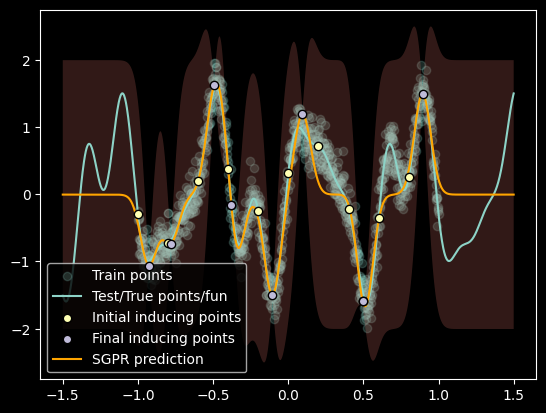

In [19]:
plt.scatter(X, y, alpha=0.2, label="Train points")
plt.plot(X_test, f_true, label="Test/True points/fun")
plt.scatter(X_locs, f_locs, zorder=99, ec="k", label="Initial inducing points")
plt.scatter(
    model.x_locs_,
    y_locs_pred,
    ec="k",
    zorder=99,
    label="Final inducing points",
)
plt.plot(X_test, y_pred, c="orange", label="SGPR prediction")
plt.fill_between(
    X_test.reshape(-1), y_pred.reshape(-1) - err, y_pred.reshape(-1) + err, alpha=0.2
)
plt.legend()

2023-04-03 12:49:25.658080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 12:49:26.230417: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-03 12:49:26.230475: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-03 12:49:26.230480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value    │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ SGPR.mean_function.c     │ Parameter │ Identity         │         │ False       │ (1,)    │ float64 │ [0.]     │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.0      │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0      │
├──────────────────────────┼───────────┼──────────────────┼─────────┼───────────

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value    │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ SGPR.mean_function.c     │ Parameter │ Identity         │         │ False       │ (1,)    │ float64 │ [0.]     │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.0      │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.26769  │
├──────────────────────────┼───────────┼──────────────────┼─────────┼───────────

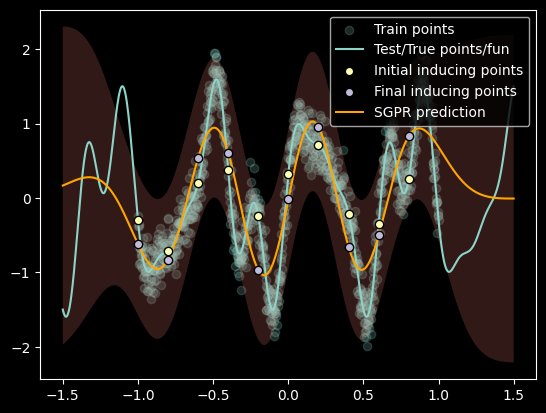

In [20]:
# Comparison with GPFlow (if available)
# Note that SGPR in GPFlow refers to Titsias (2009):
# https://proceedings.mlr.press/v5/titsias09a.html
try:
    # Without optimizing induced points
    import gpflow
    from gpflow.utilities import print_summary
    from gpflow.models import SGPR as gpf_SGPR
    from gpflow.kernels import RBF
    from gpflow.mean_functions import Constant as C
    import numpy as np

    gpf_model = gpf_SGPR(
        (np.array(X), np.array(y)),
        kernel=RBF(),
        inducing_variable=np.array(X_locs),
        mean_function=C(),
    )
    gpflow.set_trainable(gpf_model.mean_function.c, False)
    gpflow.set_trainable(gpf_model.kernel.variance, False)
    gpflow.set_trainable(gpf_model.inducing_variable.Z, False)

    print_summary(gpf_model)

    opt = gpflow.optimizers.Scipy()
    opt.minimize(gpf_model.training_loss, gpf_model.trainable_variables)

    # Note that the RBF kernel of gpflow has lengthscale *= 1/np.sqrt(2)
    # Note that is also reports the likelihood variance (sigma ** 2)
    print_summary(gpf_model)
    print(-gpf_model.training_loss())

    plt.scatter(X, y, alpha=0.2, label="Train points")
    plt.plot(X_test, f_true, label="Test/True points/fun")
    plt.scatter(X_locs, f_locs, zorder=99, ec="k", label="Initial inducing points")

    y_pred, cov_pred = gpf_model.predict_y(np.array(X_test))
    y_pred_loc, _ = gpf_model.predict_y(gpf_model.inducing_variable.variables[0])
    err = 2 * cov_pred**0.5

    y_pred_loc = y_pred_loc.numpy().reshape(-1)
    y_pred = y_pred.numpy().reshape(-1)
    err = err.numpy().reshape(-1)

    plt.scatter(
        gpf_model.inducing_variable.variables[0],
        y_pred_loc,
        ec="k",
        zorder=99,
        label="Final inducing points",
    )
    plt.plot(X_test, y_pred, c="orange", label="SGPR prediction")
    plt.fill_between(X_test.reshape(-1), y_pred - err, y_pred + err, alpha=0.2)
    plt.legend()


except ModuleNotFoundError:
    pass

In [ ]:
# Comparison with GPFlow (if available)
# Note that SGPR in GPFlow refers to Titsias (2009):
# https://proceedings.mlr.press/v5/titsias09a.html
try:
    # Optimizing inducing points
    import gpflow
    from gpflow.utilities import print_summary
    from gpflow.models import SGPR as gpf_SGPR
    from gpflow.kernels import RBF
    from gpflow.mean_functions import Constant as C
    import numpy as np

    gpf_model = gpf_SGPR(
        (np.array(X), np.array(y)),
        kernel=RBF(),
        inducing_variable=np.array(X_locs),
        mean_function=C(),
    )
    gpflow.set_trainable(gpf_model.mean_function.c, False)
    gpflow.set_trainable(gpf_model.kernel.variance, False)
    # gpflow.set_trainable(gpf_model.inducing_variable.Z, False)

    print_summary(gpf_model)

    opt = gpflow.optimizers.Scipy()
    opt.minimize(gpf_model.training_loss, gpf_model.trainable_variables)

    # Note that the RBF kernel of gpflow has lengthscale *= 1/np.sqrt(2)
    # Note that is also reports the likelihood variance (sigma ** 2)
    print_summary(gpf_model)
    print(-gpf_model.training_loss())

    plt.scatter(X, y, alpha=0.2, label="Train points")
    plt.plot(X_test, f_true, label="Test/True points/fun")
    plt.scatter(X_locs, f_locs, zorder=99, ec="k", label="Initial inducing points")

    y_pred, cov_pred = gpf_model.predict_y(np.array(X_test))
    y_pred_loc, _ = gpf_model.predict_y(gpf_model.inducing_variable.variables[0])
    err = 2 * cov_pred**0.5

    y_pred_loc = y_pred_loc.numpy().reshape(-1)
    y_pred = y_pred.numpy().reshape(-1)
    err = err.numpy().reshape(-1)

    plt.scatter(
        gpf_model.inducing_variable.variables[0],
        y_pred_loc,
        ec="k",
        zorder=99,
        label="Final inducing points",
    )
    plt.plot(X_test, y_pred, c="orange", label="SGPR prediction")
    plt.fill_between(X_test.reshape(-1), y_pred - err, y_pred + err, alpha=0.2)
    plt.legend()

except ModuleNotFoundError:
    pass